In [1]:
# only need to run this once 
# conda activate /media/data_16T/chloe/sidewalkai/.conda
!pip install opencv-contrib-python

## Get the Semantic Map 

In [2]:
from transformers import Mask2FormerImageProcessor, Mask2FormerForUniversalSegmentation, AutoImageProcessor

CONFIG = "facebook/mask2former-swin-large-cityscapes-semantic"
processor = Mask2FormerImageProcessor.from_pretrained(CONFIG)
model = Mask2FormerForUniversalSegmentation.from_pretrained(CONFIG)

/home/chia/anaconda3/envs/bizon_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from PIL import Image
import numpy as np 
import matplotlib.pyplot as plt
image = Image.open("/media/data_16T/chloe/try/IMG_5543.jpeg").convert("RGB")

inputs = processor(images=image, return_tensors="pt")

with torch.no_grad():
  outputs = model(**inputs)

In [4]:
predicted_semantic_map = processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]

In [5]:
semantic_seg_mask = predicted_semantic_map.cpu().detach().numpy()


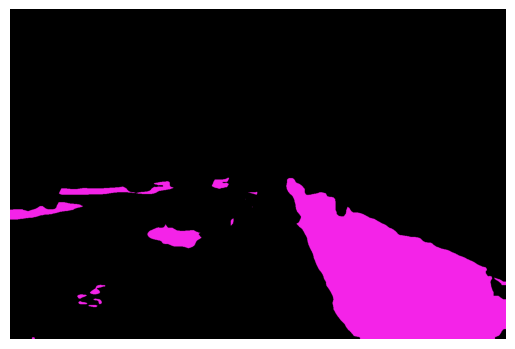

True

<Figure size 640x480 with 0 Axes>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

sidewalktocolor = {0: (0, 0, 0), 1: (244, 35, 232)}

# Create a new array where only pixels with number 1 have the color, and others are black
visualized_map = np.zeros((semantic_seg_mask.shape[0], semantic_seg_mask.shape[1], 3), dtype=np.uint8)
for i in range(semantic_seg_mask.shape[0]):
    for j in range(semantic_seg_mask.shape[1]):
        if semantic_seg_mask[i, j] == 1:
            visualized_map[i, j] = sidewalktocolor[1]

# Display the visualized segmentation map
plt.imshow(visualized_map)
plt.axis('off')
plt.show()
plt.savefig('visualized_map.png', bbox_inches='tight', pad_inches=0)

cv2.imwrite('visualized_mapp.png', visualized_map)


In [7]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt


In [8]:
image = cv2.imread('/media/data_16T/chloe/sidewalkai/visualized_mapp.png', 0)
image.shape

(931, 1400)

## Visualize all the sidewalk components 

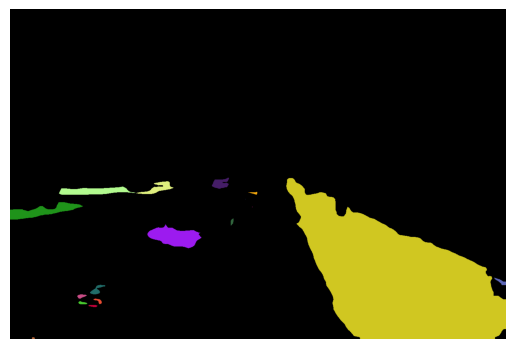

In [9]:
image = cv2.imread('/media/data_16T/chloe/sidewalkai/visualized_mapp.png', 0)
image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)

# Create a blank image to draw the labeled components
output = np.zeros_like(image_rgb, dtype=np.uint8)

# Generate a unique color for each component
colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)

# Assign colors to the labeled components
for label in range(1, num_labels):
    mask = labels == label
    output[mask] = colors[label]


output_rgb = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)

# Display the labeled components using matplotlib
plt.imshow(output_rgb)
plt.axis('off')
plt.show()

## Only visualize the largest component. I need to not only visualize the largest component but also change the class value of 

new_visualized_map has to be the new segmentation mask with only the largest component 

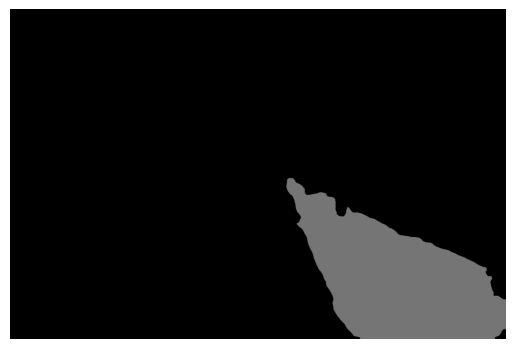

In [10]:
max_label, max_size = max([(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels)], key=lambda x: x[1])
new_visualized_map = np.zeros_like(image, dtype=np.uint8)
new_visualized_map[labels == max_label] = image[labels == max_label]
largest_component = cv2.cvtColor(new_visualized_map, cv2.COLOR_BGR2RGB)
plt.savefig("largest_component.png", bbox_inches='tight', pad_inches=0)

# Display the labeled components using matplotlib
plt.imshow(largest_component)
plt.axis('off')
plt.show()

In [11]:
largest_component.shape

(931, 1400, 3)

In [12]:
import cv2
import torch
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line

In [13]:
binary_mask = largest_component[:, :, -1] 
np.unique(binary_mask)

array([  0, 117], dtype=uint8)

## This code successfully draws the edges around the largest component. NO LINE DETECTION

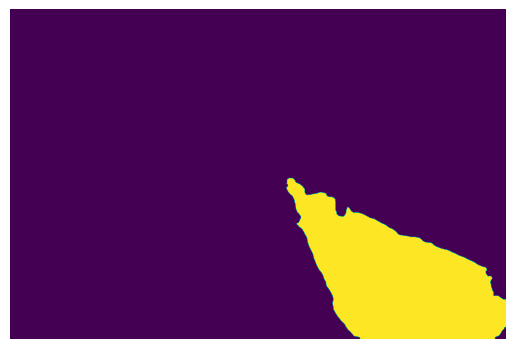

In [14]:
threshold1 = 50  # Adjust as needed
threshold2 = 150  # Adjust as needed

binary_mask = binary_mask.astype(np.uint8)

# Extract the channel corresponding to the sidewalk boundary (assuming it's the first channel)
sidewalk_boundary_channel = binary_mask

edges = cv2.Canny(sidewalk_boundary_channel, threshold1, threshold2)

contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

rho = 1  # Distance resolution in pixels
theta = np.pi / 180  # Angle resolution in radians
threshold = 100  # Minimum number of votes to consider a line
minLineLength = 100  # Minimum length of a line in pixels
maxLineGap = 10  # Maximum allowed gap between line segments in pixels
# lines = cv2.HoughLinesP(edges, rho, theta, threshold, minLineLength, maxLineGap)

leftmost_point = None
rightmost_point = None


# Iterate through the contours and find the leftmost and rightmost points
for contour in contours:
    # Get the leftmost and rightmost points of the contour
    leftmost = tuple(contour[contour[:, :, 0].argmin()][0])
    rightmost = tuple(contour[contour[:, :, 0].argmax()][0])
    
    # Update the leftmost and rightmost points
    if leftmost_point is None or leftmost[0] < leftmost_point[0]:
        leftmost_point = leftmost
    if rightmost_point is None or rightmost[0] > rightmost_point[0]:
        rightmost_point = rightmost

# for line in lines:
#     x1,y1,x2,y2 = line[0]
#     cv2.line(visualization, (x1,y1), (x2,y2), (0,0,255),2)

# Visualize the leftmost and rightmost points on the binary mask
visualization = binary_mask.copy()
cv2.circle(visualization, leftmost_point, 5, (0, 0, 255), -1)
cv2.circle(visualization, rightmost_point, 5, (0, 0, 255), -1)

image = cv2.cvtColor(visualization, cv2.COLOR_BGR2RGB)
cv2.imwrite("vi.jpg", image)
plt.imshow(visualization)
plt.axis('off')
plt.show()

## Convert the contours to line edge detection by downloading the contours image above 

In [87]:
import cv2
import numpy as np

# Read image
image = cv2.imread('/media/data_16T/chloe/sidewalkai/vi.jpg')

# Convert image to grayscale
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# Use canny edge detection
edges = cv2.Canny(gray,10,100,apertureSize=3)

# Apply HoughLinesP method to
# to directly obtain line end points
lines_list =[]
lines = cv2.HoughLinesP(
			edges, # Input edge image
			1, # Distance resolution in pixels
			np.pi/180, # Angle resolution in radians
			threshold=10, # Min number of votes for valid line
			minLineLength=2, # Min allowed length of line
			maxLineGap=10 # Max allowed gap between line for joining them
			)

# Iterate over points
for points in lines:
    # Extracted points nested in the list
    x1, y1, x2, y2 = points[0]
    # Draw the lines joining the points
    # On the original image
    length = len(lines)
    index = length / 4
    index = int(index)
    midpoint_line = lines[index]
    if (points == midpoint_line).all():
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 5)
    else: 
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    # Maintain a simple lookup list for points
    lines_list.append([(x1, y1), (x2, y2)])

# Save the result image
cv2.imwrite('lines.png', image)


True

## Get the perpendicular line 

In [15]:
# perpendicular line

import cv2
import numpy as np

# Read image
image = cv2.imread('/media/data_16T/chloe/sidewalkai/vi.jpg')

# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use Canny edge detection
edges = cv2.Canny(gray, 10, 100, apertureSize=3)

# Apply HoughLinesP method to obtain line end points
lines_list = []
lines = cv2.HoughLinesP(
    edges,  # Input edge image
    1,  # Distance resolution in pixels
    np.pi / 180,  # Angle resolution in radians
    threshold=10,  # Min number of votes for valid line
    minLineLength=2,  # Min allowed length of line
    maxLineGap=10  # Max allowed gap between line for joining them
)

# Calculate the midpoint line index
midpoint_index = len(lines) // 4

# Iterate over lines
for i, points in enumerate(lines):
    # Extracted points nested in the list
    x1, y1, x2, y2 = points[0]
    # Draw the lines joining the points on the original image
    if i == midpoint_index:
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 5)  # Draw the midpoint line in red
        midpoint_line = points[0]  # Store the midpoint line
    else:
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw other lines in green
    # Maintain a simple lookup list for points
    lines_list.append([(x1, y1), (x2, y2)])

# Calculate the negative reciprocal slope for the perpendicular line
midpoint_slope = (midpoint_line[3] - midpoint_line[1]) / (midpoint_line[2] - midpoint_line[0])
perpendicular_slope = -1 / midpoint_slope

midpoint_intercept = midpoint_line[1] - midpoint_slope * midpoint_line[0]
perpendicular_intercept = midpoint_line[3] - perpendicular_slope * midpoint_line[2]

# Calculate the start and end points for the perpendicular line
perpendicular_start_x = 0
perpendicular_start_y = int(midpoint_line[3] - perpendicular_slope * midpoint_line[2])
perpendicular_end_x = image.shape[1]
perpendicular_end_y = int(midpoint_line[3] + perpendicular_slope * (perpendicular_end_x - midpoint_line[2]))

intersection_x = (perpendicular_intercept - midpoint_intercept) / (midpoint_slope - perpendicular_slope)
intersection_y = midpoint_slope * intersection_x + midpoint_intercept

intersection_point = (int(intersection_x), int(intersection_y))
cv2.circle(image, intersection_point, 5, (0, 255, 255), 4)

# Draw the perpendicular line on the image
cv2.line(image, (perpendicular_start_x, perpendicular_start_y), (perpendicular_end_x, perpendicular_end_y),
         (255, 0, 0), 3)  # Draw the perpendicular line in blue

# Save the result image
cv2.imwrite('lines.png', image)


True

In [19]:
# perpendicular line

import cv2
import numpy as np

# Read image
image = cv2.imread('/media/data_16T/chloe/sidewalkai/vi.jpg')

# Convert image to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Use Canny edge detection
edges = cv2.Canny(gray, 10, 100, apertureSize=3)

# Apply HoughLinesP method to obtain line end points
lines_list = []
lines = cv2.HoughLinesP(
    edges,  # Input edge image
    1,  # Distance resolution in pixels
    np.pi / 180,  # Angle resolution in radians
    threshold=10,  # Min number of votes for valid line
    minLineLength=2,  # Min allowed length of line
    maxLineGap=10  # Max allowed gap between line for joining them
)

# Calculate the midpoint line index
midpoint_index = len(lines) // 4

# Iterate over lines
for i, points in enumerate(lines):
    # Extracted points nested in the list
    x1, y1, x2, y2 = points[0]
    # Draw the lines joining the points on the original image
    if i == midpoint_index:
        cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 5)  # Draw the midpoint line in red
        midpoint_line = points[0]  # Store the midpoint line
    else:
        cv2.line(image, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Draw other lines in green
    # Maintain a simple lookup list for points
    lines_list.append([(x1, y1), (x2, y2)])

# Calculate the negative reciprocal slope for the perpendicular line
midpoint_slope = (midpoint_line[3] - midpoint_line[1]) / (midpoint_line[2] - midpoint_line[0])
perpendicular_slope = -1 / midpoint_slope

midpoint_intercept = midpoint_line[1] - midpoint_slope * midpoint_line[0]
perpendicular_intercept = midpoint_line[3] - perpendicular_slope * midpoint_line[2]

# Calculate the start and end points for the perpendicular line
perpendicular_start_x = 0
perpendicular_start_y = int(midpoint_line[3] - perpendicular_slope * midpoint_line[2])
perpendicular_end_x = image.shape[1]
perpendicular_end_y = int(midpoint_line[3] + perpendicular_slope * (perpendicular_end_x - midpoint_line[2]))

cv2.line(image, (perpendicular_start_x, perpendicular_start_y), (perpendicular_end_x, perpendicular_end_y),
         (255, 0, 0), 3)

for line in lines_list:
    x1, y1 = line[0]
    x2, y2 = line[1]
    # Calculate the intersection point between the perpendicular line and the current line
    intersection_x = (perpendicular_intercept - midpoint_intercept) / (midpoint_slope - perpendicular_slope)
    intersection_y = midpoint_slope * intersection_x + midpoint_intercept

    intersection_point = (int(intersection_x), int(intersection_y))
    cv2.circle(image, intersection_point, 5, (0, 255, 255), 4)

cv2.imwrite('lines.png', image)

True

In [16]:
length = len(lines)
index = length/4
index = int(index)
lines[index]

array([[850, 681, 858, 698]], dtype=int32)

In [78]:
for points in lines:
    print(points)
    break

[[1033  595 1045  601]]


In [37]:
image.shape

(931, 1400, 3)

In [33]:
binary_mask = binary_mask.astype(np.uint8) * 255
np.unique(binary_mask)

array([  0, 117], dtype=uint8)

In [26]:
binary_mask = largest_component[:, :, -1]
binary_mask.shape

(931, 1400)

In [31]:
third_channel = largest_component[:, :, :2]
third_channel.shape

(931, 1400, 2)

## Line Edge Detection

In [ ]:
contours

In [54]:
gray

(480, 640)

In [49]:
np.unique(binary_mask)

array([  0, 255], dtype=uint8)

In [46]:
np.unique(edges)

array([False])

In [24]:
binary_mask.shape

(480, 640, 2)

In [25]:
image.shape

(480, 640, 3)

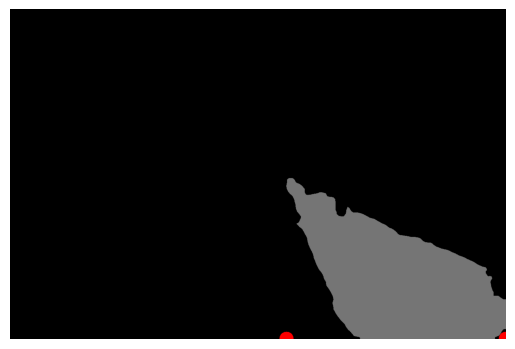

In [31]:
import cv2
import numpy as np

# Create a copy of the largest_component image
visualization_image = largest_component.copy()

# Draw red dots on the leftmost and rightmost pixels
cv2.circle(visualization_image, (leftmost_pixel, y), 20, (0, 0, 255), -1)
cv2.circle(visualization_image, (rightmost_pixel, y), 20, (0, 0, 255), -1)

# Display the image with the red dots
circle = cv2.cvtColor(visualization_image, cv2.COLOR_BGR2RGB)

# Display the labeled components using matplotlib
plt.imshow(circle)
plt.axis('off')
plt.show()


In [14]:

# x/y coordinates of the top left corner 
# x-coordinate of the bounding box
# y-coordinate position of the bounding box

array([[      0,       0,    1400,     931, 1135173],
       [    570,     476,      48,      31,     990],
       [    780,     477,     620,     454,  150774],
       [    356,     486,     105,      36,    1423],
       [    138,     501,     216,      23,    3178],
       [    673,     516,      25,       8,      99],
       [    664,     536,       1,       1,       1],
       [      0,     545,     206,      49,    4301],
       [    683,     558,       2,       1,       2],
       [    623,     591,       8,      20,     112],
       [    388,     607,     152,      68,    5933],
       [   1367,     758,      33,      21,     268],
       [    226,     778,      43,      27,     482],
       [    190,     805,      27,      12,     202],
       [    236,     817,      23,      16,     161],
       [    193,     824,      25,       9,     146],
       [    221,     835,      26,       6,     118],
       [     62,     926,       8,       5,      37]], dtype=int32)

In [41]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=4)
max_label, max_size = max([(i, stats[i, cv2.CC_STAT_AREA]) for i in range(1, num_labels)], key=lambda x: x[1])
max_size # contains the maximum largest component, not all the values in STATS is a component
output = np.zeros_like(image, dtype=np.uint8)
colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)
for label in range(1, num_labels):
    mask = labels == label
    output[mask] = colors[label]

# Display the labeled components
cv2.imshow('Connected Components', output)

ValueError: NumPy boolean array indexing assignment cannot assign 3 input values to the 990 output values where the mask is true

In [43]:
image.shape

(931, 1400)

In [17]:
from PIL import Image
image = Image.open('/media/data_16T/chloe/try/sidewalkmask.png')

# Convert the image to grayscale if needed
image = image.convert('L')

# Retrieve pixel data
pixel_values = list(image.getdata())
np.unique(pixel_values)

array([ 89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101,
       102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114,
       115, 116, 117, 118, 119, 120, 255])

In [13]:
image.shape

(480, 640)

In [9]:
num_labels

2

In [31]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)

In [33]:
labels

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=int32)

In [19]:
cv2.CC_STAT_AREA

4

In [2]:
img = cv2.imread('/media/data_16T/chloe/try/sidewalkmask.png')




gray_img = cv2.cvtColor(img , cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray_img, (7, 7), 0)
threshold = cv2.threshold(blurred, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
analysis = cv2.connectedComponentsWithStats(threshold,
											4,
											cv2.CV_32S)
(totalLabels, label_ids, values, centroid) = analysis
np.unique(values)

array([     0,     77,     80,    330,    480,    496,    640, 143524,
       163676], dtype=int32)

In [3]:
imgy = cv2.imread('/media/data_16T/chloe/try/sidewalkmask.png')
imgy.shape

(480, 640, 3)

In [4]:
# Initialize a new image to store
# all the output components
output = np.zeros(gray_img.shape, dtype="uint8")

In [5]:
for i in range(1, totalLabels):
    	
	# Area of the component
	area = values[i, cv2.CC_STAT_AREA]
	
	if (area > 10000000000000000000):
		componentMask = (label_ids == i).astype("uint8") * 255
		output = cv2.bitwise_or(output, componentMask)

In [12]:
def imshow(template):
    plt.imshow(cv2.cvtColor(template, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

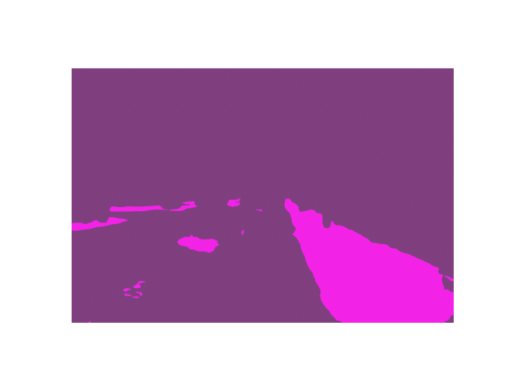

In [13]:
imggg = cv2.imread('/media/data_16T/chloe/try/sidewalkmask.png')
imshow(imggg)

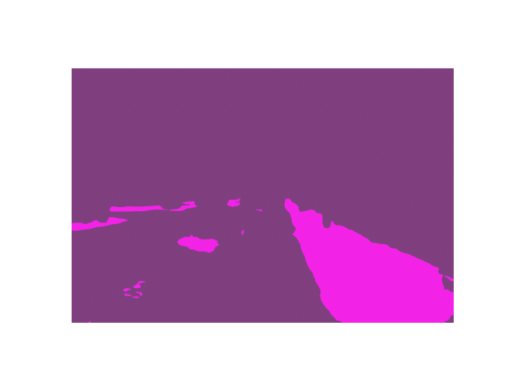

In [7]:
# image = cv2.imread('/media/data_16T/chloe/sidewalkai/massave.png')

# Display the image using the defined imshow function
imshow(img)

In [24]:
image_path = '/media/data_16T/chloe/try/sidewalkmask.png'
seg_mask = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
seg_mask.shape

(480, 640)

In [ ]:
# Set the area threshold for connected components
area_threshold = 200000

# Perform connected component analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(seg_mask, connectivity=8)

# the number of unique labels in the array labels is 1. 
# Create a blank mask for the new image
new_image = np.zeros_like(seg_mask)

# Iterate through each component
for label in range(1, num_labels):  # Exclude background label 0
    # Check if the area of the component is larger than the threshold
    if stats[label, cv2.CC_STAT_AREA] > area_threshold:
        # Find the pixels belonging to the component and set them in the new image
        new_image[labels == label] = 123

imshow(new_image)
# Save the new image
cv2.imwrite("new_image.png", new_image)


In [1]:
import io
import cv2
import requests
from PIL import Image
from requests_toolbelt.multipart.encoder import MultipartEncoder

# Load Image with PIL
img = cv2.imread("/media/data_16T/chloe/sidewalkai/St-Petersburg-4th-St-sidewalk-2711-CROP.jpeg")
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pilImage = Image.fromarray(image)

# Convert to JPEG Buffer
buffered = io.BytesIO()
pilImage.save(buffered, quality=100, format="JPEG")

# Build multipart form and post request
m = MultipartEncoder(fields={'file': ("imageToUpload", buffered.getvalue(), "image/jpeg")})

response = requests.post("https://detect.roboflow.com/your-model/your-model-version?api_key=pbjZL2yLm1Oom8Mtfi4Y", data=m, headers={'Content-Type': m.content_type})

print(response)
print(response.json())

KeyboardInterrupt: 

In [5]:
import roboflow

rf = roboflow.Roboflow(api_key="pbjZL2yLm1Oom8Mtfi4Y")

# List all projects for your workspace
workspace = rf.workspace()

# get a project
project = rf.workspace().project("hard-hat-sample-iwnzz")

# List all versions of a specific project
project.versions()

loading Roboflow workspace...
loading Roboflow workspace...
loading Roboflow project...


In [ ]:
# Load Image with PIL
img = cv2.imread("/media/data_16T/chloe/sidewalkai/St-Petersburg-4th-St-sidewalk-2711-CROP.jpeg")
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
pilImage = Image.fromarray(image)

# Convert to JPEG Buffer
buffered = io.BytesIO()
pilImage.save(buffered, quality=100, format="JPEG")

# Build multipart form and post request
m = MultipartEncoder(fields={'file': ("imageToUpload", buffered.getvalue(), "image/jpeg")})

response = requests.post("https://detect.roboflow.com/your-model/your-model-version?api_key=your-api-key", data=m, headers={'Content-Type': m.content_type})

print(response)
print(response.json())